# <center> **Classification** <center>

In [1]:
from src import *
import numpy as np
from tqdm import tqdm
from statistics import mean, stdev
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import FormatStrFormatter
from collections import Counter
import glob


2025-03-09 13:37:27.406326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define parameters

In [2]:
class_sizes = [4,10]
data_percentages = [10, 20, 30, 40, 50]
n_folds = 5

# Titles for each metric
metric_titles = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
# Titles for data series
models_title = ['Complete', 'Subsampled','GPDM5', 'GPDM7','GPDM9', 'CGAN', 'CVAE', 'CGAN-clean', 'CVAE-clean','GPNN5', 'GPNN7','GPNN9']

try:
    # Loading metrics
    with open(f'./results/metrics.pkl', 'rb') as file:
        metrics = pickle.load(file)
except:
    metrics = {}
    

## Load data

In [3]:
paths_dict_list = []
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './data',substring_to_replace = 'test'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './data',substring_to_replace = 'train'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './data',substring_to_replace = 'train_subsampled'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpdm5',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpdm7',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpdm9',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/cgan',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/cvae',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/cgan_c',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/cvae_c',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpnn5',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpnn7',substring_to_replace = 'train_synthetic'))
paths_dict_list.append(utils.get_sorted_paths_dict(
    data_directory  = './results/gpnn9',substring_to_replace = 'train_synthetic'))

## Classify data and save metrics

In [22]:
utils.set_seeds(seed_value=0)
cm = classifier.ClassificationMetrics(n_runs=5)

total_iterations = len(class_sizes)*len(data_percentages)*n_folds
with tqdm(total=total_iterations, desc="Overall Progress") as pbar:
    for C in class_sizes:
        for P in data_percentages:
            for K in range(n_folds):


                X_test = np.load(paths_dict_list[0][C,P][K][0])
                Y_test = np.load(paths_dict_list[0][C,P][K][1])

                X_train = np.load(paths_dict_list[1][C,P][K][0])
                Y_train = np.load(paths_dict_list[1][C,P][K][1])

                X_train_subsampled = np.load(paths_dict_list[2][C,P][K][0])
                Y_train_subsampled = np.load(paths_dict_list[2][C,P][K][1])

                metrics[(C,P,K,1)] = cm.average_metrics(X_train, Y_train, X_test, Y_test)
                metrics[(C,P,K,2)] = cm.average_metrics(X_train_subsampled, Y_train_subsampled, X_test, Y_test)

                for model_idx in range(3,len(paths_dict_list)):
                    X_train_synthetic = np.load(paths_dict_list[model_idx][C,P][K][0])
                    Y_train_synthetic = np.load(paths_dict_list[model_idx][C,P][K][1])
                    metrics[(C,P,K,model_idx)] = cm.average_metrics(X_train_synthetic, Y_train_synthetic, X_test, Y_test)
                pbar.update(1)

# Saving mean_ratio_dict
with open(f'./results/metrics.pkl', 'wb') as file:
    pickle.dump(metrics, file)

Overall Progress: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


## Plot the performance metrics of one-shot generative model (GPDM)

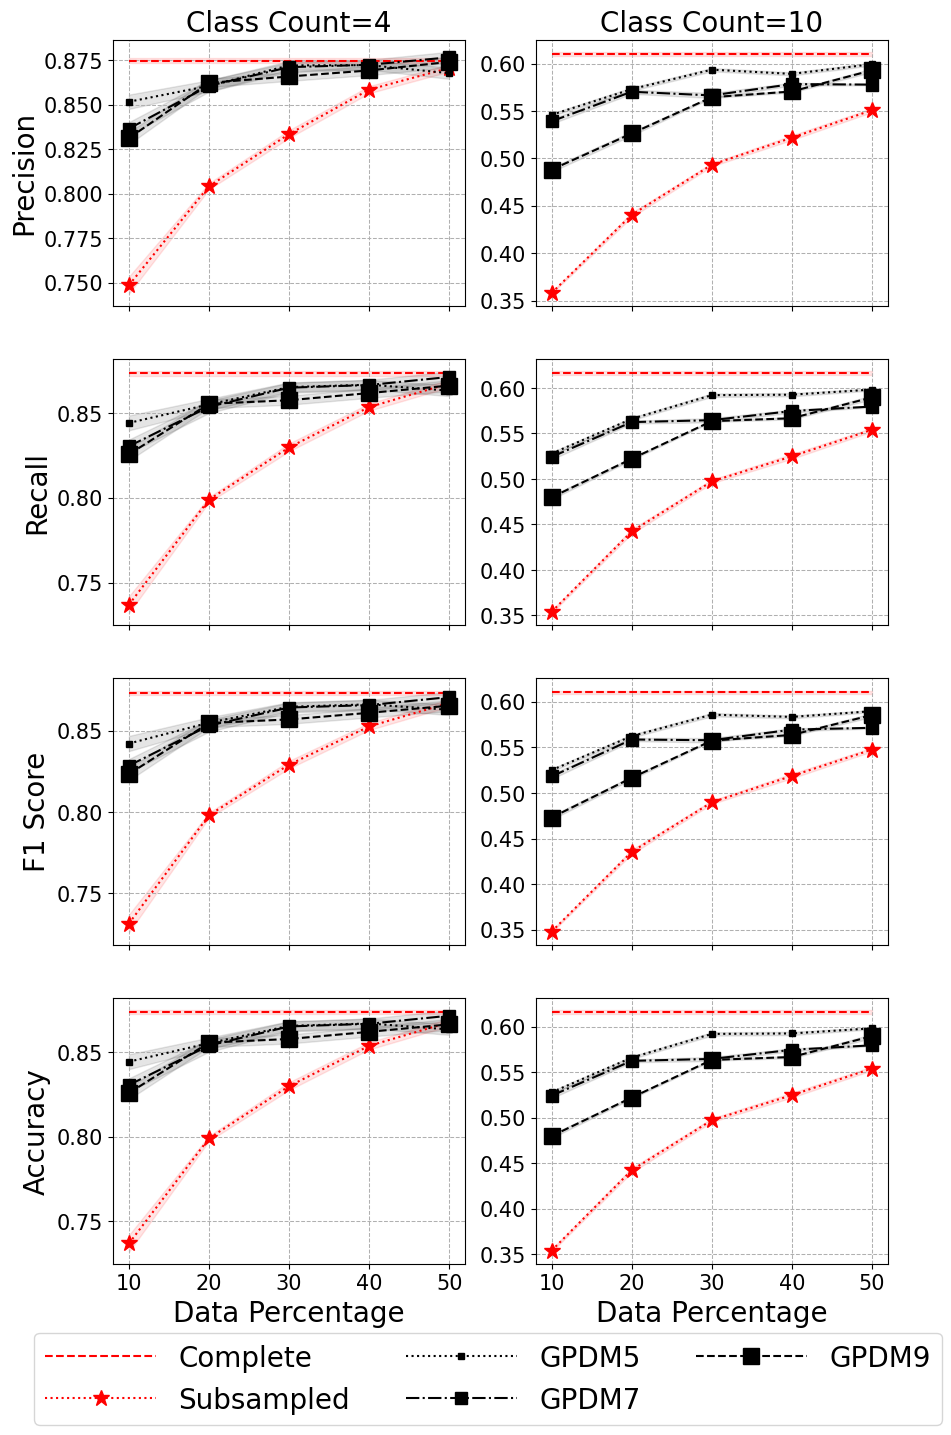

In [11]:
# Reformat data to be grouped by C, P, and idx to be able to average over K.
grouped_metrics = {}
for (C, P, K, idx), values in metrics.items():
    key = (C, P, idx)
    if key not in grouped_metrics:
        grouped_metrics[key] = []
    grouped_metrics[key].append(values)

# Calculate average and standard deviation over K.
averaged_metrics = {key: np.mean(vals, axis=0) for key, vals in grouped_metrics.items()}
stddev_metrics = {key: np.std(vals, axis=0) for key, vals in grouped_metrics.items()}

# Extract unique C, P, and idx values for plotting.
C_values = sorted(set(key[0] for key in grouped_metrics))
P_values = sorted(set(key[1] for key in grouped_metrics))
idx_values = sorted(set(key[2] for key in grouped_metrics))

# Adjusting global font sizes
plt.rcParams['font.size'] = 15         # Default font size
plt.rcParams['axes.titlesize'] = 25    # Axes title font size
plt.rcParams['axes.labelsize'] = 20    # X and Y axis label font size
plt.rcParams['xtick.labelsize'] = 15   # X axis tick labels
plt.rcParams['ytick.labelsize'] = 15   # Y axis tick labels
plt.rcParams['legend.fontsize'] = 20   # Legend font size

fig, axs = plt.subplots(4, 2, figsize=(10, 15.9))
line_styles = ['--',':',':', '-.', '--']
marker_styles = ['','*','s','s','s']
markersizes = [ 10, 12, 4, 8, 12]
colors = ['r','r','k','k','k','k','k']
# Plot each metric in the 2x2 subplot structure with the specified scales and fill
for i, metric_title in enumerate(metric_titles):
    for j, C in enumerate(C_values):
        #if C==10: continue
        ax = axs[i, j]
         
        if j == 0:
            ax.set_ylabel(metric_title)
        if i == 0:
            ax.set_title(f'Class Count={C}', fontsize = 20)
        if i!=3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Data Percentage')
            
        # Always include indices 1 and 2, then add indices of elements containing 'GP' (converted to 1-based)
        idx_values = [1, 2] + [i + 1 for i, title in enumerate(models_title) if 'GPDM' in title]
        for count,idx in enumerate(idx_values):
            # Extract the metric values for the current C and idx across all P
            metric_values = np.array([averaged_metrics[(C, P, idx)][i] for P in P_values])
            stddev_values = np.array([stddev_metrics[(C, P, idx)][i] for P in P_values])
            line_style = line_styles[count]
            marker_style = marker_styles[count]
            # Plot the average metric value and fill between the standard deviation
            ax.plot(P_values, metric_values,
                    label=f'{models_title[idx-1]}',
                    linestyle = line_style,
                    marker = marker_style,
                    markersize=markersizes[count],
                    color=colors[count])
            ax.fill_between(P_values,
                            metric_values - 0.1*stddev_values,
                            metric_values + 0.1*stddev_values,
                            color=colors[count],
                            alpha=0.1)
            ax.grid(True, which='both', linestyle='--', linewidth=0.75)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.00), ncol=3 , handlelength=4)

# Save the figure
plt.savefig('metrics_gpdm.pdf', format='pdf', bbox_inches='tight')

## Plot the performance metrics of one-shot generative model (GPNN)

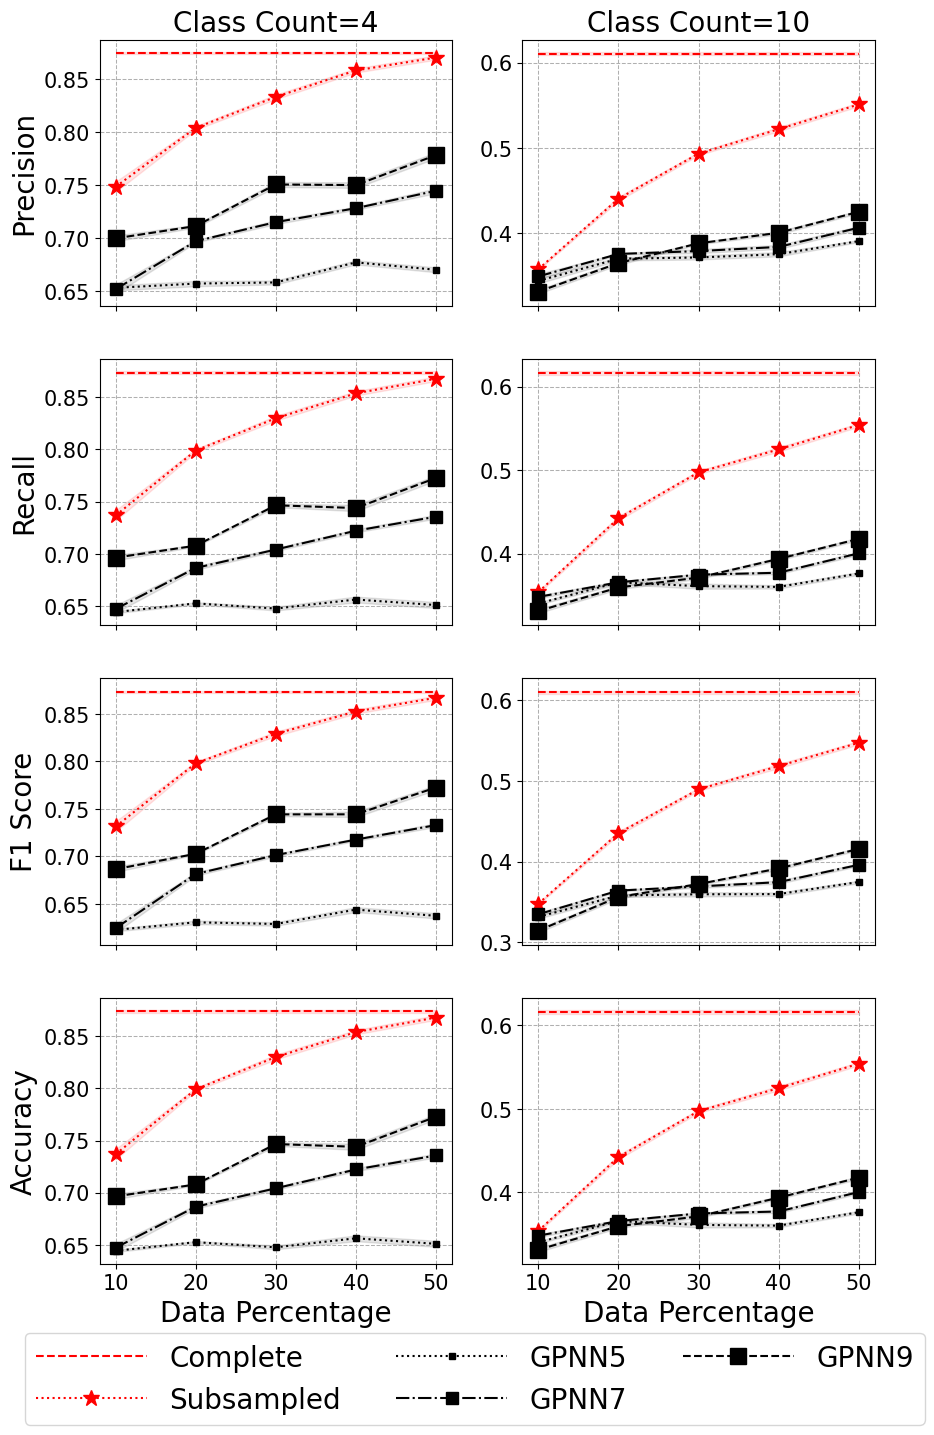

In [7]:
# Reformat data to be grouped by C, P, and idx to be able to average over K.
grouped_metrics = {}
for (C, P, K, idx), values in metrics.items():
    key = (C, P, idx)
    if key not in grouped_metrics:
        grouped_metrics[key] = []
    grouped_metrics[key].append(values)

# Calculate average and standard deviation over K.
averaged_metrics = {key: np.mean(vals, axis=0) for key, vals in grouped_metrics.items()}
stddev_metrics = {key: np.std(vals, axis=0) for key, vals in grouped_metrics.items()}

# Extract unique C, P, and idx values for plotting.
C_values = sorted(set(key[0] for key in grouped_metrics))
P_values = sorted(set(key[1] for key in grouped_metrics))
idx_values = sorted(set(key[2] for key in grouped_metrics))

# Adjusting global font sizes
plt.rcParams['font.size'] = 15         # Default font size
plt.rcParams['axes.titlesize'] = 25    # Axes title font size
plt.rcParams['axes.labelsize'] = 20    # X and Y axis label font size
plt.rcParams['xtick.labelsize'] = 15   # X axis tick labels
plt.rcParams['ytick.labelsize'] = 15   # Y axis tick labels
plt.rcParams['legend.fontsize'] = 20   # Legend font size

fig, axs = plt.subplots(4, 2, figsize=(10, 15.9))
line_styles = ['--',':',':', '-.', '--']
marker_styles = ['','*','s','s','s']
markersizes = [ 10, 12, 4, 8, 12]
colors = ['r','r','k','k','k','k','k']
# Plot each metric in the 2x2 subplot structure with the specified scales and fill
for i, metric_title in enumerate(metric_titles):
    for j, C in enumerate(C_values):
        #if C==10: continue
        ax = axs[i, j]
         
        if j == 0:
            ax.set_ylabel(metric_title)
        if i == 0:
            ax.set_title(f'Class Count={C}', fontsize = 20)
        if i!=3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Data Percentage')
            
        # Always include indices 1 and 2, then add indices of elements containing 'GPNN' (converted to 1-based)
        idx_values = [1, 2] + [i + 1 for i, title in enumerate(models_title) if 'GPNN' in title]
        for count,idx in enumerate(idx_values):
            # Extract the metric values for the current C and idx across all P
            metric_values = np.array([averaged_metrics[(C, P, idx)][i] for P in P_values])
            stddev_values = np.array([stddev_metrics[(C, P, idx)][i] for P in P_values])
            line_style = line_styles[count]
            marker_style = marker_styles[count]
            # Plot the average metric value and fill between the standard deviation
            ax.plot(P_values, metric_values,
                    label=f'{models_title[idx-1]}',
                    linestyle = line_style,
                    marker = marker_style,
                    markersize=markersizes[count],
                    color=colors[count])
            ax.fill_between(P_values,
                            metric_values - 0.1*stddev_values,
                            metric_values + 0.1*stddev_values,
                            color=colors[count],
                            alpha=0.1)
            ax.grid(True, which='both', linestyle='--', linewidth=0.75)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.00), ncol=3 , handlelength=4)

# Save the figure
#plt.savefig('metrics_gpdm.pdf', format='pdf', bbox_inches='tight')
plt.savefig('metrics_gpnn.pdf', format='pdf', bbox_inches='tight')

## Plot the performance metrics of CGAN and CVAE

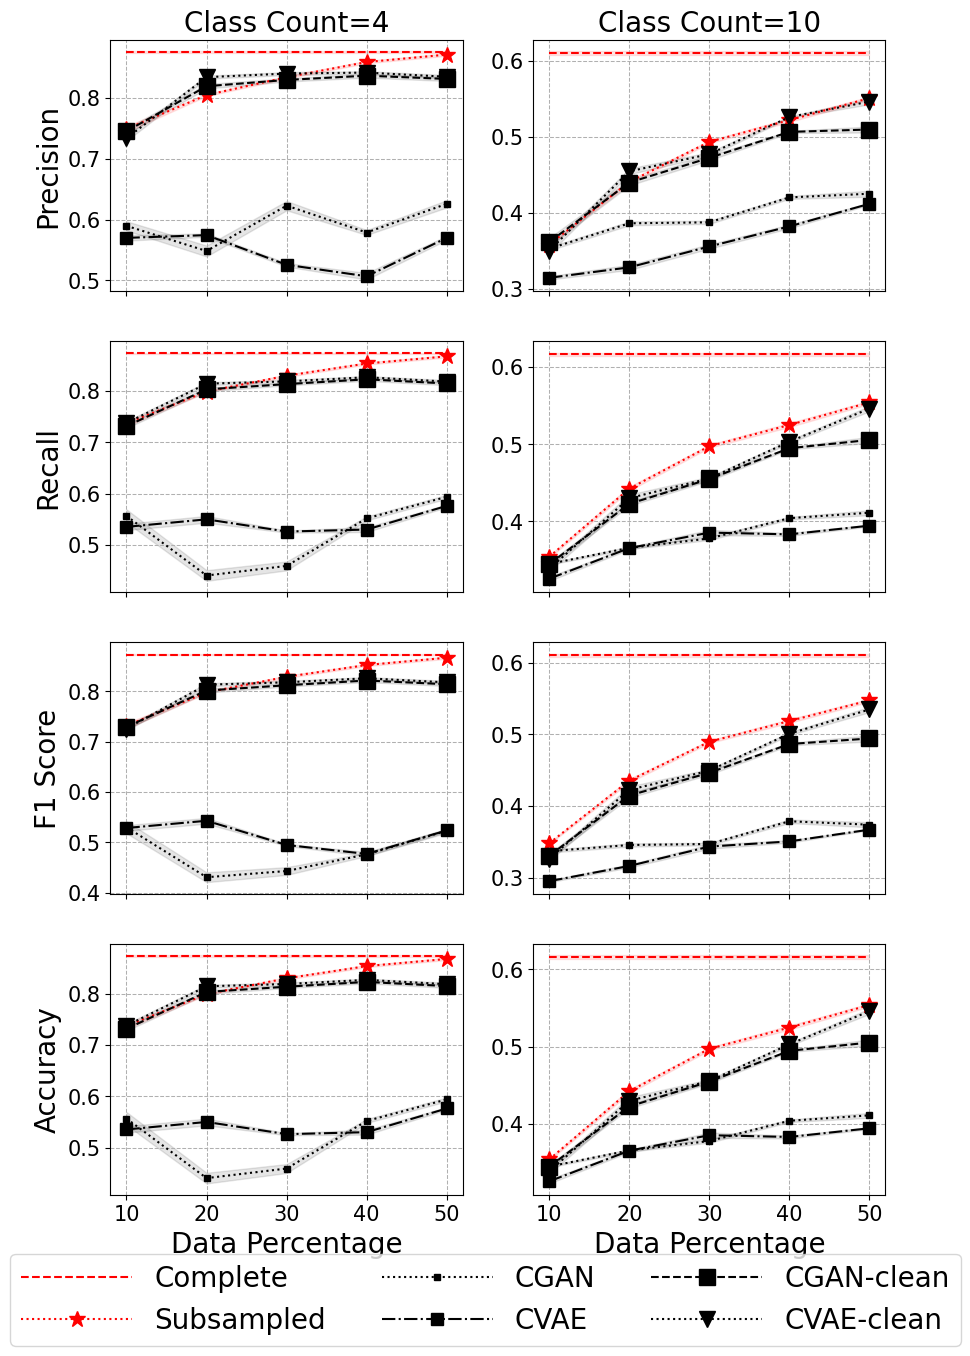

In [13]:
# Reformat data to be grouped by C, P, and idx to be able to average over K.
grouped_metrics = {}
for (C, P, K, idx), values in metrics.items():
    key = (C, P, idx)
    if key not in grouped_metrics:
        grouped_metrics[key] = []
    grouped_metrics[key].append(values)

# Calculate average and standard deviation over K.
averaged_metrics = {key: np.mean(vals, axis=0) for key, vals in grouped_metrics.items()}
stddev_metrics = {key: np.std(vals, axis=0) for key, vals in grouped_metrics.items()}

# Extract unique C, P, and idx values for plotting.
C_values = sorted(set(key[0] for key in grouped_metrics))
P_values = sorted(set(key[1] for key in grouped_metrics))
idx_values = sorted(set(key[2] for key in grouped_metrics))

# Adjusting global font sizes
plt.rcParams['font.size'] = 15         # Default font size
plt.rcParams['axes.titlesize'] = 25    # Axes title font size
plt.rcParams['axes.labelsize'] = 20    # X and Y axis label font size
plt.rcParams['xtick.labelsize'] = 15   # X axis tick labels
plt.rcParams['ytick.labelsize'] = 15   # Y axis tick labels
plt.rcParams['legend.fontsize'] = 20   # Legend font size

fig, axs = plt.subplots(4, 2, figsize=(10, 15))
line_styles = ['--',':',':', '-.', '--',':','--',':','--']
marker_styles = ['','*','s','s','s','v','^','<','>']
markersizes = [ 10, 12, 4, 8, 12, 12, 12, 12, 12]
colors = ['r','r','k','k','k','k','k','k','k']
# Plot each metric in the 2x2 subplot structure with the specified scales and fill
for i, metric_title in enumerate(metric_titles):
    for j, C in enumerate(C_values):
        #if C==10: continue
        ax = axs[i, j]
         

        if j == 0:
            ax.set_ylabel(metric_title)
        if i == 0:
            ax.set_title(f'Class Count={C}', fontsize = 20)
        if i!=3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Data Percentage')
        
        idx_values = [1, 2] + [i + 1 for i, title in enumerate(models_title) if any(sub in title for sub in ['CGAN', 'CVAE'])]
        for count, idx in enumerate(idx_values):
            # Extract the metric values for the current C and idx across all P
            metric_values = np.array([averaged_metrics[(C, P, idx)][i] for P in P_values])
            stddev_values = np.array([stddev_metrics[(C, P, idx)][i] for P in P_values])
            line_style = line_styles[count]
            marker_style = marker_styles[count]
            # Plot the average metric value and fill between the standard deviation
            ax.plot(P_values, metric_values,
                    label=f'{models_title[idx-1]}',
                    linestyle = line_style,
                    marker = marker_style,
                    markersize=markersizes[count],
                    color=colors[idx-1])
            ax.fill_between(P_values,
                            metric_values - 0.1*stddev_values,
                            metric_values + 0.1*stddev_values,
                            color=colors[count],
                            alpha=0.1)
            ax.grid(True, which='both', linestyle='--', linewidth=0.75)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.00), ncol=3 , handlelength=4)

# Save the figure
plt.savefig('metrics_conditional.pdf', format='pdf', bbox_inches='tight')